Creamos datos sintéticos...

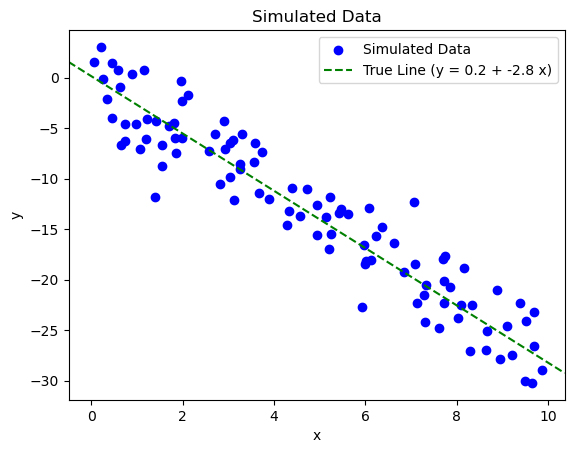

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as smf
import scipy.stats as sps


# Set a random seed for reproducibility
np.random.seed(42)

N = 100 # number of datapoints
# Generate independent variable x
x = np.random.uniform(low=0, high=10, size=N)  # N random points between 0 and 10
a_true = np.random.uniform(low=0, high=5, size=1)[0]
b_true = np.random.normal(loc=0, scale=2, size=1)[0]

# Define the true relationship with some noise
# y = 1 + x + noise
noise = np.random.normal(loc=0, scale=3, size=N)  # Normal noise with mean 0 and std deviation 1
y = a_true + b_true*x + noise

# Plot the simulated data
plt.scatter(x, y, color='blue', label='Simulated Data')
plt.title('Simulated Data')
plt.xlabel('x')
plt.ylabel('y')
plt.axline((0, a_true), slope=b_true, color='green', linestyle='--', label=f'True Line (y = {a_true:0.1f} + {b_true:0.1f} x)')
plt.legend()
plt.show()


Construimos un modelo lineal para estos datos y visualizamos sus predicciones

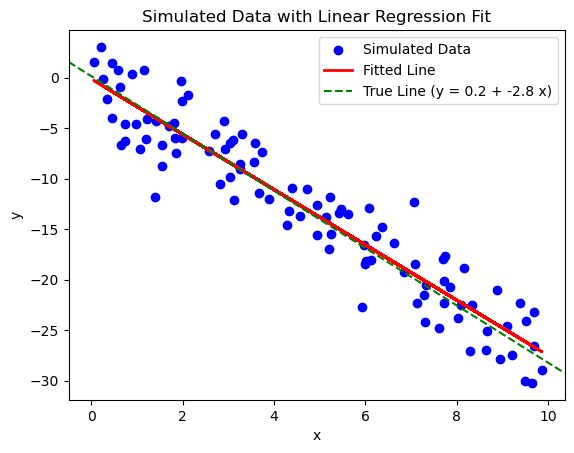

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     854.0
Date:                Tue, 29 Oct 2024   Prob (F-statistic):           3.51e-50
Time:                        18:19:15   Log-Likelihood:                -242.91
No. Observations:                 100   AIC:                             489.8
Df Residuals:                      98   BIC:                             495.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1174      0.521     -0.226      0.8

In [137]:
# build table with data
data = pd.DataFrame({'milk': x, 'y': y})

# Fit the linear regression model using statsmodels
model = smf.ols(formula="y~1+milk", data=data).fit()

# Get the fitted values
data['y_fit'] = model.predict()

# Plot the simulated data
plt.scatter(data['milk'], data['y'], color='blue', label='Simulated Data')
plt.plot(data['milk'], data['y_fit'], color='red', label='Fitted Line', linewidth=2)
plt.title('Simulated Data with Linear Regression Fit')
plt.xlabel('x')
plt.ylabel('y')
plt.axline((0, a_true), slope=b_true, color='green', linestyle='--', label=f'True Line (y = {a_true:0.1f} + {b_true:0.1f} x)')
plt.legend()
plt.show()

# Print the regression results
print(model.summary())

La distribución de los parámetros estimados en este modelo lineal es Gaussiana. Podemos visualizarla

Text(0.5, 1.0, 'Intercept distribution')

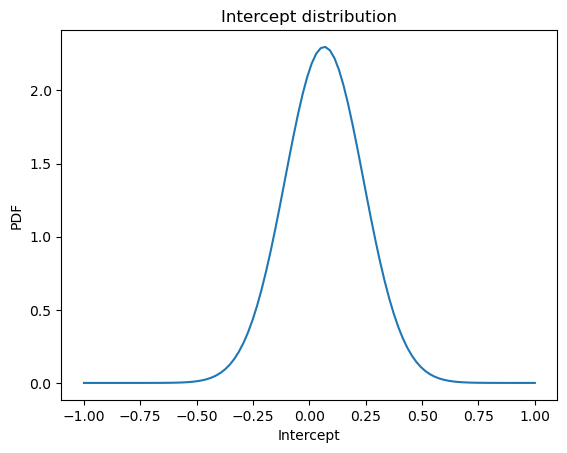

In [4]:
interc_range = np.linspace(start=-1, stop=1, num=100)
interc_pdf = sps.norm.pdf(x=interc_range, loc=model.params.Intercept, scale=model.bse.Intercept)
plt.plot(interc_range, interc_pdf)
plt.xlabel("Intercept")
plt.ylabel("PDF")
plt.title("Intercept distribution")

Text(0.5, 1.0, 'Slope distribution')

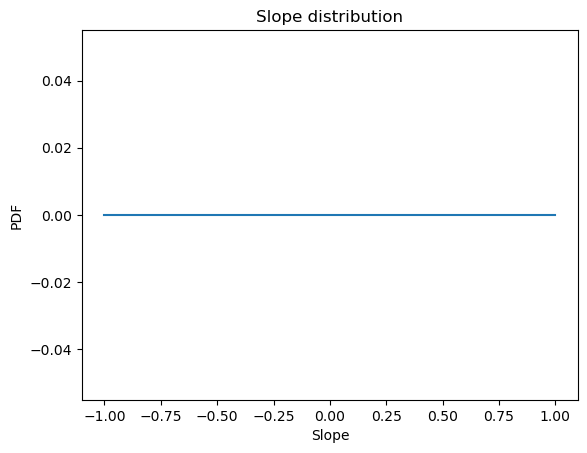

In [5]:
slope_range = np.linspace(start=-1, stop=1, num=100)
slope_pdf = sps.norm.pdf(x=slope_range, loc=model.params.x, scale=model.bse.x)
plt.plot(slope_range, slope_pdf)
plt.xlabel("Slope")
plt.ylabel("PDF")
plt.title("Slope distribution")

Pendiente y correlación

In [138]:
def center_scale_transform(x, center=0, scale=1):
    return (x - center) / scale

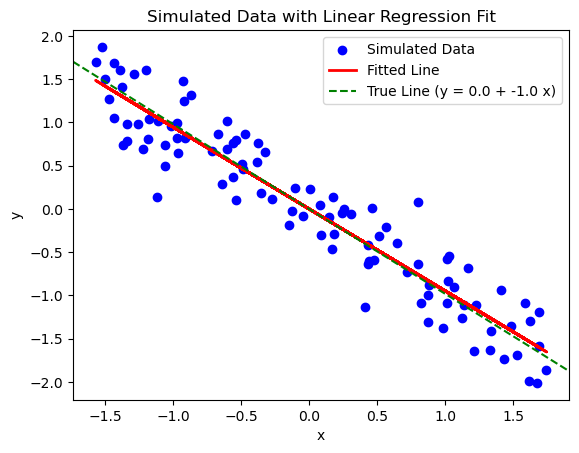

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     854.0
Date:                Tue, 29 Oct 2024   Prob (F-statistic):           3.51e-50
Time:                        18:22:12   Log-Likelihood:                -28.214
No. Observations:                 100   AIC:                             60.43
Df Residuals:                      98   BIC:                             65.64
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6.939e-17      0.032   2.14e-15      1.0

In [139]:
data_scaled = pd.DataFrame({'x': center_scale_transform(x, center=x.mean(), scale=x.std()),
                     'y': center_scale_transform(y, center=y.mean(), scale=y.std())})

# Fit the linear regression model using statsmodels
model_scaled= smf.ols(formula="y~1+x", data=data_scaled).fit()

# Get the fitted values
data_scaled['y_fit'] = model_scaled.predict()

# Plot the simulated data
plt.scatter(data_scaled['x'], data_scaled['y'], color='blue', label='Simulated Data')
plt.plot(data_scaled['x'], data_scaled['y_fit'], color='red', label='Fitted Line', linewidth=2)
plt.title('Simulated Data with Linear Regression Fit')
plt.xlabel('x')
plt.ylabel('y')
plt.axline((0, 0), slope=b_true/(y.std()/x.std()), color='green', linestyle='--', label=f'True Line (y = {0:0.1f} + {b_true/(y.std()/x.std()):0.1f} x)')
plt.legend()
plt.show()

# Print the regression results
print(model_scaled.summary())

In [140]:
corr_res = sps.pearsonr(x, y)
print(f"Pearson's correlation coefficient: {corr_res.statistic}")

Pearson's correlation coefficient: -0.9471317271986015


Si queremos volver a la escala original solo hemos de transformar los parámetros estimados

In [9]:
slope_unstandardized = model_scaled.params.x * y.std()/x.std()
intercept_unstandardized = y.mean() - slope_unstandardized * x.mean()
print(f"Unstandardized intercept: {intercept_unstandardized:0.3f}, unstandardized slope: {slope_unstandardized:0.3f}")

Unstandardized intercept: 0.066, unstandardized slope: -2.804


Predicción

Podemos crear una tabla con los valores de la variable independiente para los que queremos una predicción

In [10]:
predict_data = pd.DataFrame(dict(x=[11, 10]))
predict_data

,x
0,11
1,10


In [11]:
model.predict(exog=predict_data)

0   -30.783874
1   -27.979374
dtype: float64

o podemos leer una tabla desde un excel (hay funciones para leer otros formatos)

In [27]:
predict_data = pd.read_excel("data_to_predict.xlsx")
model.predict(exog=predict_data)

0    -30.783874
1    -27.979374
2    -34.429723
3   -280.384308
dtype: float64

Error de predicción

           x          y      y_fit     error
80  8.631034 -25.200568 -24.193387  1.007181
81  6.232981 -16.911303 -17.452525 -0.541222
82  3.308980  -8.015018  -9.233237 -1.218219
83  0.635584  -1.420035  -1.718391 -0.298357
84  3.109823  -7.819579  -8.673412 -0.853833
85  3.251833  -8.895101  -9.072598 -0.177498
86  7.296062 -21.762291 -20.440815  1.321476
87  6.375575 -16.884206 -17.853351 -0.969145
88  8.872127 -23.692418 -24.871093 -1.178675
89  4.722149 -12.507456 -13.205617 -0.698161
90  1.195942  -4.190839  -3.293545  0.897294
91  7.132448 -20.832361 -19.980901  0.851460
92  7.607850 -22.560565 -21.317245  1.243320
93  5.612772 -14.999122 -15.709133 -0.710011
94  7.709672 -20.450665 -21.603462 -1.152797
95  4.937956 -13.429822 -13.812244 -0.382421
96  5.227328 -13.734867 -14.625662 -0.890794
97  4.275410 -12.841975 -11.949845  0.892130
98  0.254191  -0.418260  -0.646308 -0.228048
99  1.078914  -4.274145  -2.964582  1.309563


Text(0, 0.5, 'frequency')

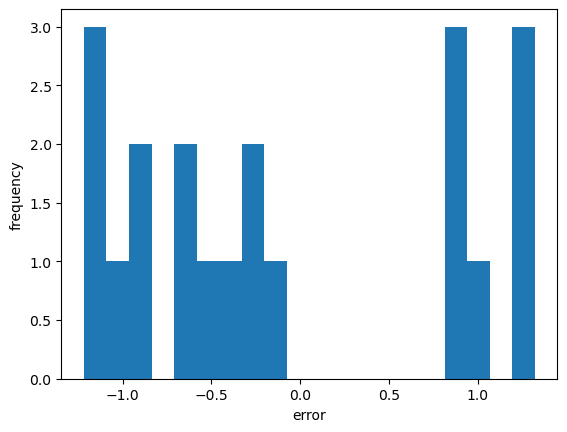

In [131]:
# build table with data
data = pd.DataFrame({'x': x, 'y': y})

# Fit the linear regression model using statsmodels
N_train = int(N*.8)
data_train = data.loc[:N_train, :].copy()
data_test = data.loc[N_train:, :].copy()
model = smf.ols(formula="y~1+x", data=data_train).fit()

# Get the predicted values
data_test['y_fit'] = model.predict(exog=data_test)
data_test["error"] = data_test['y_fit'] - data_test['y']
print(data_test)
plt.hist(data_test["error"], bins=20);
plt.xlabel("error")
plt.ylabel("frequency")

R cuadrado

La R^2 es una métrica que indica la bondad de ajuste del modelo a los datos. Más en concreto representa el porcentaje de varianza de los datos explicado por el modelo.
Se calcula como:
$$ 1 - \frac{\sum_{i=1}^N (y_i-\hat{y}_i)^2}{\sum_{i=1}^N (y_i-\bar{y}_i)^2} $$

Regresor categórico

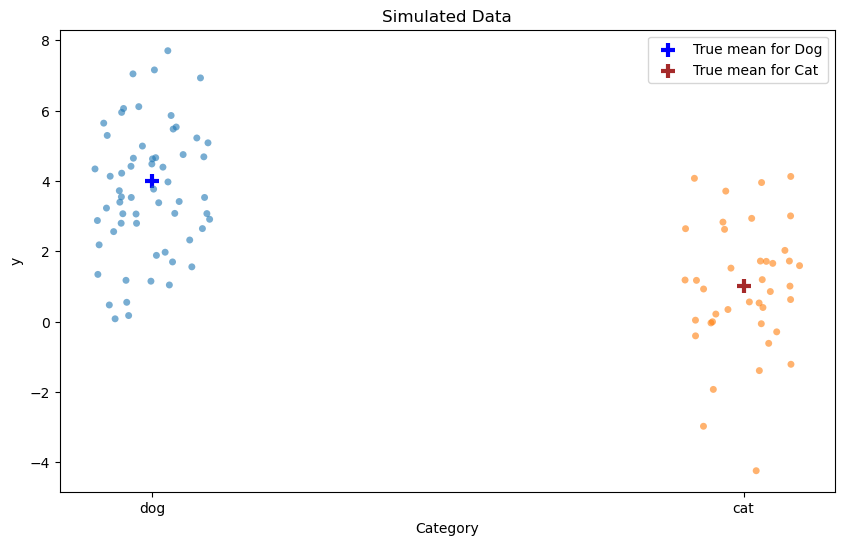

In [103]:
# Set a random seed for reproducibility
np.random.seed(42)

N = 100  # number of datapoints

# Generate the true relationship parameters
dog_mean = 4
cat_mean = 1
n_dog = int(N*0.6)
y_dog = np.random.normal(loc=dog_mean, scale=2, size=n_dog)  # x for 'dog'
y_cat = np.random.normal(loc=cat_mean, scale=2, size=N-n_dog)  # x for 'cat'
dog_df = pd.DataFrame(dict(animal="dog", y=y_dog))
cat_df = pd.DataFrame(dict(animal="cat", y=y_cat))
# Create a DataFrame to hold the data
data = pd.concat((dog_df, cat_df))

# Plot the simulated data using a strip plot
plt.figure(figsize=(10, 6))
sns.stripplot(x='animal', y='y', data=data, jitter=True, hue='animal', alpha=0.6)

# Add true mean for each category
plt.scatter(x="dog", y=dog_mean, color='blue', marker="+", s=100, lw=3, label=f'True mean for Dog')
plt.scatter(x="cat", y=cat_mean, color='brown', marker="+", s=100, lw=3, label=f'True mean for Cat')

plt.title('Simulated Data')
plt.xlabel('Category')
plt.ylabel('y')
plt.legend()
plt.show()


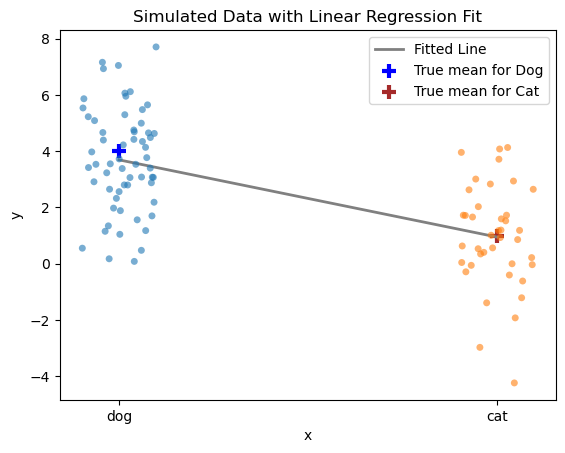

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.358
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     54.56
Date:                Sat, 26 Oct 2024   Prob (F-statistic):           5.04e-11
Time:                        14:25:23   Log-Likelihood:                -200.84
No. Observations:                 100   AIC:                             405.7
Df Residuals:                      98   BIC:                             410.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.9447      0.288      3.281

In [104]:
# Fit the linear regression model using statsmodels
model = smf.ols(formula="y~1+animal", data=data).fit()

# Get the fitted values
data['y_fit'] = model.predict()

# Plot the simulated data
sns.stripplot(x='animal', y='y', data=data, jitter=True, hue='animal', alpha=0.6)
plt.plot(data['animal'], data['y_fit'], color='grey', label='Fitted Line', linewidth=2)
plt.title('Simulated Data with Linear Regression Fit')
plt.xlabel('x')
plt.ylabel('y')
# Add true mean for each category
plt.scatter(x="dog", y=dog_mean, color='blue', marker="+", s=100, lw=3, label=f'True mean for Dog')
plt.scatter(x="cat", y=cat_mean, color='brown', marker="+", s=100, lw=3, label=f'True mean for Cat')
plt.legend()
plt.show()

# Print the regression results
print(model.summary())

Un modelo lineal con datos categóricos estima las medias de las categorías.

In [105]:
data.groupby("animal").mean("y")

,y,y_fit
animal,,
cat,0.944731,0.944731
dog,3.690691,3.690691


In [109]:
print(f"Cat mean: {model.params.Intercept:.3f}")
print(f"Dog mean: {model.params.Intercept+model.params["animal[T.dog]"]:.3f}")

Cat mean: 0.945
Cat mean: 3.691


Cuál es la distribución de la diferencia entre las medias?

Las medias son parámetros del modelo linear y como hemos visto estos parámetros tienes distribucíon Gaussiana.
La diferencia de dos Gaussianas tiene distribución Gaussiana también con media igual a la diferencia entre las médias y varianza igual a la suma de las varianzas.

Text(0.5, 1.0, 'Distribution of difference of means')

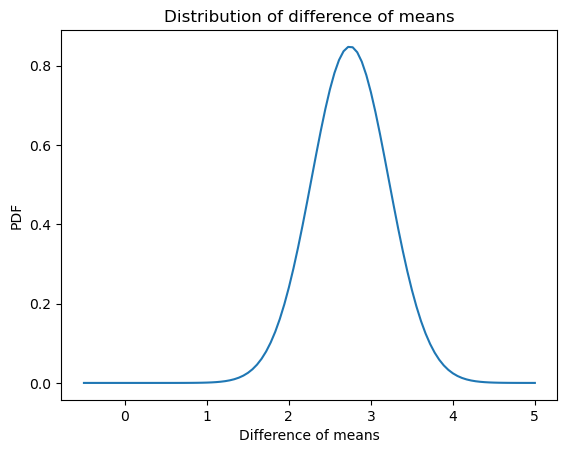

In [113]:
mean_diff = model.params.Intercept+model.params["animal[T.dog]"] - model.params.Intercept
var_diff = model.bse.Intercept**2 + model.bse["animal[T.dog]"]**2
diff_range = np.linspace(start=-0.5, stop=5, num=100)
diff_pdf = sps.norm.pdf(x=diff_range, loc=mean_diff, scale=np.sqrt(var_diff))
plt.plot(diff_range, diff_pdf)
plt.xlabel("Difference of means")
plt.ylabel("PDF")
plt.title("Distribution of difference of means")

Podemos usar un modelo lineal para estimar la media de un solo grupo? Cómo?

Más de dos categorías

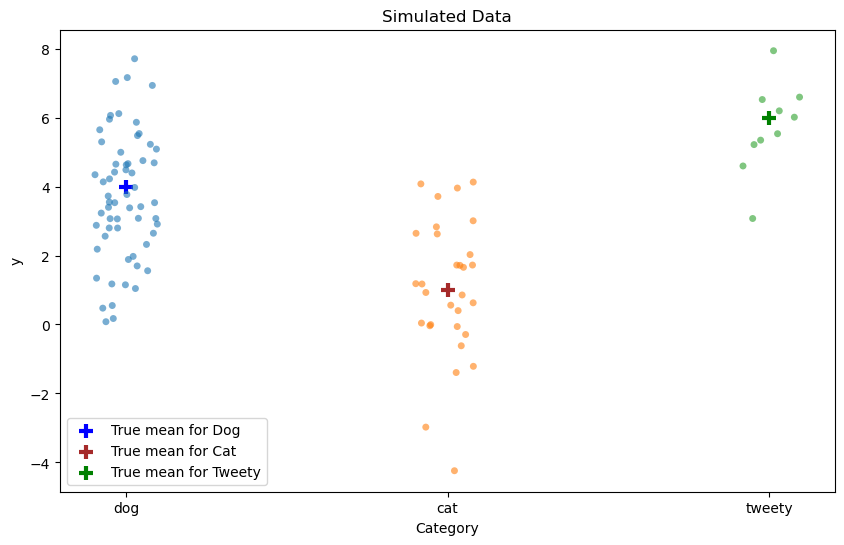

In [95]:
# Set a random seed for reproducibility
np.random.seed(42)

N = 100  # number of datapoints

# Generate the true relationship parameters
dog_mean = 4
cat_mean = 1
tweety_mean = 6
n_dog = int(N*0.6)
n_cat = int(N*.3)
y_dog = np.random.normal(loc=dog_mean, scale=2, size=n_dog)  # y for 'dog'
y_cat = np.random.normal(loc=cat_mean, scale=2, size=n_cat)  # y for 'cat'
y_tweety = np.random.normal(loc=tweety_mean, scale=2, size=N-n_cat-n_dog)  # y for 'tweety'
dog_df = pd.DataFrame(dict(animal="dog", y=y_dog))
cat_df = pd.DataFrame(dict(animal="cat", y=y_cat))
tweety_df = pd.DataFrame(dict(animal="tweety", y=y_tweety))
# Create a DataFrame to hold the data
data = pd.concat((dog_df, cat_df, tweety_df))

# Plot the simulated data using a strip plot
plt.figure(figsize=(10, 6))
sns.stripplot(x='animal', y='y', data=data, jitter=True, hue='animal', alpha=0.6)

# Add true mean for each category
plt.scatter(x="dog", y=dog_mean, color='blue', marker="+", s=100, lw=3, label=f'True mean for Dog')
plt.scatter(x="cat", y=cat_mean, color='brown', marker="+", s=100, lw=3, label=f'True mean for Cat')
plt.scatter(x="tweety", y=tweety_mean, color='green', marker="+", s=100, lw=3, label=f'True mean for Tweety')

plt.title('Simulated Data')
plt.xlabel('Category')
plt.ylabel('y')
plt.legend()
plt.show()


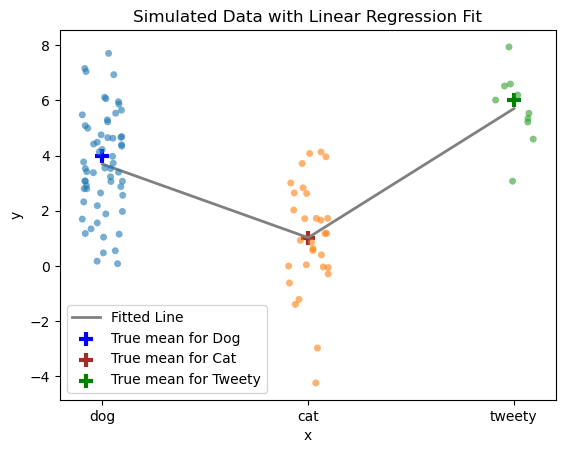

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     32.56
Date:                Sat, 26 Oct 2024   Prob (F-statistic):           1.52e-11
Time:                        14:21:05   Log-Likelihood:                -200.71
No. Observations:                 100   AIC:                             407.4
Df Residuals:                      97   BIC:                             415.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.0258      0.334  

In [98]:
# Fit the linear regression model using statsmodels
model = smf.ols(formula="y~1+animal", data=data).fit()

# Get the fitted values
data['y_fit'] = model.predict()

# Plot the simulated data
sns.stripplot(x='animal', y='y', data=data, jitter=True, hue='animal', alpha=0.6)
plt.plot(data['animal'], data['y_fit'], color='grey', label='Fitted Line', linewidth=2)
plt.title('Simulated Data with Linear Regression Fit')
plt.xlabel('x')
plt.ylabel('y')
# Add true mean for each category
plt.scatter(x="dog", y=dog_mean, color='blue', marker="+", s=100, lw=3, label=f'True mean for Dog')
plt.scatter(x="cat", y=cat_mean, color='brown', marker="+", s=100, lw=3, label=f'True mean for Cat')
plt.scatter(x="tweety", y=tweety_mean, color='green', marker="+", s=100, lw=3, label=f'True mean for Tweety')
plt.legend()
plt.show()

# Print the regression results
print(model.summary())

Crea una función que simule datos con una variable categórica

crea una función que calcula la diferencia entre las medias de las categorias

Haz 100 simulaciones, calcula para cada una la diferencia entre las medias y dibuja un histograma de estas diferencias.

## Multiples dimensiones

### Visualizaciones

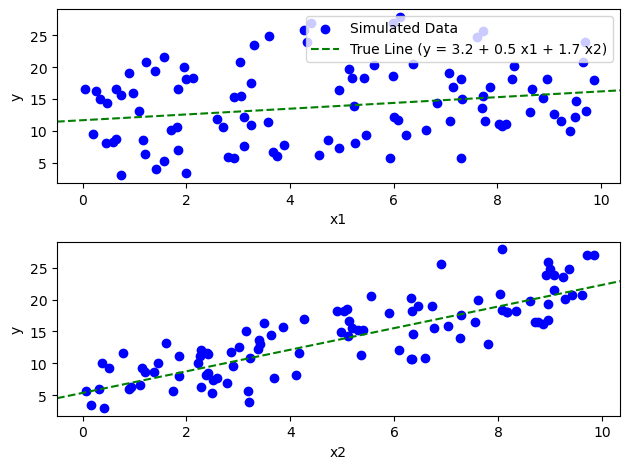

In [75]:
# Set a random seed for reproducibility
np.random.seed(42)

N = 100 # number of datapoints
# Generate independent variable x
x1 = np.random.uniform(low=0, high=10, size=N)  # N random points between 0 and 10
x2 = np.random.uniform(low=0, high=10, size=N)  # N random points between 0 and 10
a_true = np.random.uniform(low=0, high=5, size=1)[0]
b1_true = np.random.normal(loc=0, scale=2, size=1)[0]
b2_true = np.random.normal(loc=0, scale=2, size=1)[0]

# Define the true relationship with some noise
# y = 1 + x + noise
noise = np.random.normal(loc=0, scale=3, size=N)  # Normal noise with mean 0 and std deviation 1
y = a_true + b1_true*x1 + b2_true*x2 + noise

# Plot the simulated data
fig, axs = plt.subplots(nrows=2)
axs[0].scatter(x1, y, color='blue', label='Simulated Data')
axs[0].set_xlabel('x1')
axs[0].set_ylabel('y')
axs[0].axline((0, a_true+b2_true*x2.mean()), slope=b1_true, color='green', linestyle='--', label=f'True Line (y = {a_true:0.1f} + {b1_true:0.1f} x1 + {b2_true:0.1f} x2)')
axs[0].legend()
axs[1].scatter(x2, y, color='blue', label='Simulated Data')
axs[1].set_xlabel('x2')
axs[1].set_ylabel('y')
axs[1].axline((0, a_true+b1_true*x1.mean()), slope=b2_true, color='green', linestyle='--', label=f'True Line (y = {a_true:0.1f} + {b1_true:0.1f} x1 + {b2_true:0.1f} x2)')
plt.tight_layout()
plt.show()

In [76]:
sim_data = pd.DataFrame({"x1": x1, "x2": x2, "y": y})

In [77]:
melted_data = sim_data.melt(id_vars="y", value_vars=("x1", "x2"), value_name="regressor value", var_name="regressor")

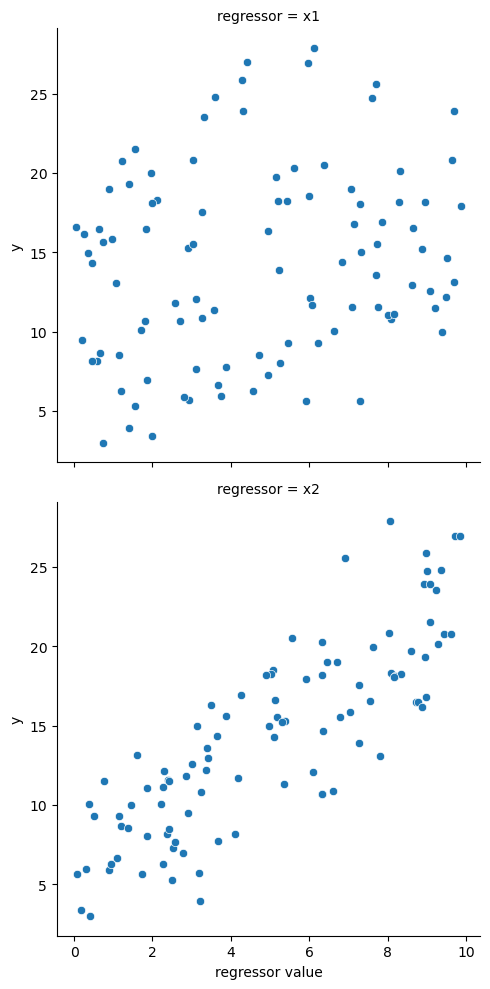

In [78]:
import seaborn as sns

sns.relplot(data=melted_data, x="regressor value", y="y", row="regressor")

### Regression Model

In [80]:
# Fit the linear regression model using statsmodels
model = smf.ols(formula="y~1+x1+x2", data=sim_data).fit()

# Get the fitted values
sim_data['y_fit'] = model.predict()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     151.1
Date:                Tue, 12 Nov 2024   Prob (F-statistic):           1.60e-30
Time:                        12:50:01   Log-Likelihood:                -249.32
No. Observations:                 100   AIC:                             504.6
Df Residuals:                      97   BIC:                             512.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.5110      0.765      4.587      0.000       1.992       5.030
x1             0.4634      0.100      4.612      0.000       0.264       0.663
x2             1.7243      0.102     16.906      0.000       1.522       1.927
==============================================================================
Omnibus:                        2.479   Durbin-Watson:                   1.891
Prob(Omnibus):                  0.289   Jarque-Bera (JB):                1.662
Skew:                           0.059   Prob(JB):                        0.436
Kurtosis:                       2.379   Cond. No.                         19.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Try with 3 variables: simulate, visualize and build a regression model.

# Binary dependent variable: logistic regression

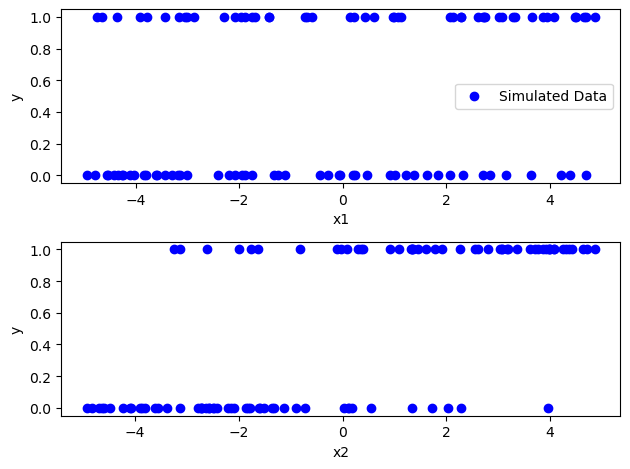

In [56]:
# Set a random seed for reproducibility
np.random.seed(42)

N = 100 # number of datapoints
# Generate independent variable x
x1 = np.random.uniform(low=-5, high=5, size=N)  # N random points between 0 and 10
x2 = np.random.uniform(low=-5, high=5, size=N)  # N random points between 0 and 10
a_true = np.random.uniform(low=-1, high=1, size=1)[0]
b1_true = np.random.normal(loc=0, scale=1, size=1)[0]
b2_true = np.random.normal(loc=0, scale=1, size=1)[0]

# Define the true relationship with some noise
# y = 1 + x + noise
# noise = np.random.normal(loc=0, scale=3, size=N)  # Normal noise with mean 0 and std deviation 1
linear_combination = a_true + b1_true*x1 + b2_true*x2
prob = 1 / (1 + np.exp(-linear_combination))
y = np.random.binomial(1, prob)

# Plot the simulated data
fig, axs = plt.subplots(nrows=2)
axs[0].scatter(x1, y, color='blue', label='Simulated Data')
axs[0].set_xlabel('x1')
axs[0].set_ylabel('y')
# axs[0].axline((0, a_true+b2_true*x2.mean()), slope=b1_true, color='green', linestyle='--', label=f'True Line (y = {a_true:0.1f} + {b1_true:0.1f} x1 + {b2_true:0.1f} x2)')
axs[0].legend()
axs[1].scatter(x2, y, color='blue', label='Simulated Data')
axs[1].set_xlabel('x2')
axs[1].set_ylabel('y')
# axs[1].axline((0, a_true+b1_true*x1.mean()), slope=b2_true, color='green', linestyle='--', label=f'True Line (y = {a_true:0.1f} + {b1_true:0.1f} x1 + {b2_true:0.1f} x2)')
plt.tight_layout()
plt.show()

In [63]:
sim_data = pd.DataFrame({"x1": x1, "x2": x2, "y": y})
# Fit the linear regression model using statsmodels
model = smf.logit(formula="y~1+x1+x2", data=sim_data).fit()

# Get the fitted values
sim_data['y_fit'] = model.predict()
model.summary()

Optimization terminated successfully.
         Current function value: 0.318009
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                          Logit   Df Residuals:                       97
Method:                           MLE   Df Model:                            2
Date:                Tue, 12 Nov 2024   Pseudo R-squ.:                  0.5412
Time:                        09:21:16   Log-Likelihood:                -31.801
converged:                       True   LL-Null:                       -69.315
Covariance Type:            nonrobust   LLR p-value:                 5.105e-17
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1376      0.317      0.434      0.664      -0.484       0.760
x1             0.4925      0.144      3.413      0.001       0.210       0.775
x2             0.9809      0.195      5.035      0.000       0.599       1.363
==============================================================================
"""